In [227]:
# default_exp core
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Aifont Core

> Core functions for Aifont

In [228]:
#hide
from nbdev.showdoc import *

## Test parameter optimisation

In [229]:
#export
from aifont.fontlearner import *
from aifont.ocrlearner import *

import ffmpeg
import gc
import IPython.display
import numpy as np
import PIL
import pydiffvg
import torch
from torch import Tensor
import skimage
import skimage.io
import subprocess
from typing import Callable, List, Protocol, Tuple, Union
from warnings import warn
from fastai.data.all import *
from fastai.vision.all import *

def read_image(fn: str) -> Tensor:
    """Read an image and return a normalised rgba tensor."""
    return Tensor(skimage.io.imread(fn) / 255.)

def report(msg: str) -> None:
    """Clear output and print a message."""
    IPython.display.clear_output(wait=True)
    print(msg)

def s(x):
    if not isinstance(x, Tensor): x = torch.tensor(x)
    return 1/(1 + torch.exp(-x))

def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    """From fastbook.utils"""
    import matplotlib as mpl
    mpl.rcParams['savefig.dpi']= 200
    mpl.rcParams['font.size']=12
    x = torch.linspace(min,max,steps=None)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

In [238]:
class VectorRenderLayerBase(Module):
    """Base for vector render layers. Get's input from a FontParamLayer
       and returns the diffvg rendering. Override `create_scenes` in
       subclasses and save the results in `self.scenes` of which there
       should be `bs`. `forward` calls `render` which renders the ch
       scenes and permutes to match the OCR model. Note that the workflow
       is based on greyscale images and we're only using the alpha value
       of the diffvg render output. Init parameters:
       `canvas_width`, `canvas_height`: rastered canvas dims
       `raster_norm`: use the normaliser from the OCR `dls`
       `clip_raster`: whether to clip color values to [0., 1.] as is done when
            saving image (note that the values produced by the render
            function value wildly up to more than 10. so setting this to
            False is advised against)
       `apply_gamma`: whether to apply `gamma` to the color values similarly
            to clipping above
       `n_distance_params`: number of params with tanh activation
       `n_width_params`: number of params with sigmoid activation
       `eps`: amount of random jitter added to `distance_params` 
       `n_colors_out`: color channels out
       `max_distance`: the maximum fraction [0., 1.] of canvas dims 
            `distance_params` can span
       `fixed_seed`: fixed seed value to pass to `pydiffvg.RenderFunction`
       `gamma`: set to override default gamma of 2.2 for colour images and 1.
            for grayscale ones
       `stroke_width`: stroke width for shape generator helpers
            (note that this is defined as a fraction of `canvas_size`);
            either a float or a tuple of min and max width and used by
            `expand_stroke_width`
       `stroke_color`: default stroke color for shape generator helpers
       `rendered_callback`: set to an ImageSaver to save interim renders"""
    batch_i = -1
    bs: int = None
    eps_tensor: Tensor = None
    scenes: List[Scene] = []
    x: Tensor = None
    def __init__(self, canvas_width: int, canvas_height: int, raster_norm: Normaliser = None,
                 n_distance_params = 1, n_width_params = 1, eps = 1e-6, clip_raster = True,
                 apply_gamma = True, n_colors_out = 1, max_distance = 1., fixed_seed: int = None, 
                 gamma: float = None, stroke_width: Union[float, Tuple[float, float]] = 1./28, 
                 stroke_color = DIFFVG_BLACK, 
                 rendered_callback: Callable[[Tensor, int, int, Scene, bool, float], None] = None):
        super(VectorRenderLayerBase, self).__init__()
        self.canvas_size = max(canvas_width, canvas_height)
        stroke_width = tensor(stroke_width)
        if canvas_width != canvas_height: 
            warn(f"When canvas is not square ({canvas_width}x{canvas_height}), "
                  "some dimensions may be expanded outside it.")
        n_width_params = n_width_params or 0
        if gamma is None: gamma = 1. if n_colors_out == 1 else 2.2
        store_attr()

    def get_item(self, i: int) -> Tensor:
        """Get item `i` in the batch `x`"""
        return self.x[i]

    def get_distance_params(self, i: int) -> Tensor:
        """`distance_params` for item `i` in the batch passed by 
           `FontParamLayer` as part of `x`"""
        return self.get_item(i)[:self.n_distance_params]

    def get_width_params(self, i: int) -> Tensor:
        """`width_params` for item `i` in the batch passed by 
           `FontParamLayer` as part of `x`"""
        return self.get_item(i)[self.n_distance_params : self.n_distance_params + self.n_width_params]

    def get_inputs(self, i: int) -> Tensor:
        """`bs` number of letter categories for item `i` in the batch passed 
            by `FontParamLayer` as part of `x`"""
        return self.get_item(i)[self.n_distance_params + self.n_width_params :]

    @property
    def eps(self) -> float:
        return self._eps

    @eps.setter
    def eps(self, value: float):
        self._eps = value
        self.eps_tensor = None

    def add_eps(self) -> None:
        """Apply random eps to distance params. Cf. diffvg/apps/generative 
           modeling/rendering.render_lines"""
        assert self.bs is not None
        if not self.eps or not self.n_distance_params: return
        if self.eps_tensor is None:
            # Premake a tensor that has eps values matching distance_params
            # in the input, i.e. the first items on each row, and zeros elsewhere
            self.eps_tensor = torch.column_stack((torch.full((self.bs, self.n_distance_params), self.eps),
                                                  torch.zeros(self.bs, self.x.size(1) - self.n_distance_params)))
        self.x = self.x + self.eps_tensor * torch.randn_like(self.x)

    def expand_distance(self, vals: Tensor) -> Tensor:
        """Expand values based on `[-m, m]` where `m = self.max_distance` 
           central coordinates."""
        return (.5 * (vals + 1.) * self.max_distance + (1 - self.max_distance) / 2) * self.canvas_size

    def expand_stroke_width(self, vals: Tensor = None) -> Tensor:
        """Expand `vals`,  based on `[min_stroke_width, max_stroke_width] * canvas_height`."""
        if vals is None: vals = tensor(1.)
        w = vals * self.stroke_width if self.stroke_width.ndim == 0 \
            else self.stroke_width[0] + vals * (self.stroke_width[1] - self.stroke_width[0])
        return w * self.canvas_size

    def normalise_raster(self, raster: Tensor) -> Tensor:
        if not self.raster_norm: return raster
        return (raster - self.raster_norm.mean) / self.raster_norm.std 

    def forward(self, x) -> Tensor:
        self.batch_i += 1
        self.x = x
        self.bs = x.size(0)
        self.add_eps()
        self.scenes = [None] * self.bs
        self.create_scenes()
        return self.render()

    def create_scenes(self) -> None:
        raise NotImplementedError()

    def create_line_scene(self, *shapes) -> Scene:
        """Create a simple line-drawing Scene with shapes."""
        shape_groups = [pydiffvg.ShapeGroup(shape_ids=tensor(list(range(len(shapes)))),
                                            fill_color=None,
                                            stroke_color=self.stroke_color,
                                            use_even_odd_rule=False)]
        return Scene(shapes=shapes, shape_groups=shape_groups, 
                     canvas_width = self.canvas_width, canvas_height = self.canvas_height)

    def create_line_scene_from_points(self, *point_tensors, stroke_width=None) -> Scene:
        return self.create_line_scene(*self.points_to_polygons(*point_tensors, stroke_width=stroke_width))

    def points_to_polygons(self, *point_tensors, stroke_width=None) -> List[pydiffvg.Polygon]:
        return [pydiffvg.Polygon(points=pt, 
                                 stroke_width=self.expand_stroke_width() if stroke_width is None else stroke_width,
                                 is_closed=False) \
                for pt in point_tensors]


    def render(self) -> Tensor:
        assert self.scenes is not None and len(self.scenes) == self.bs
        cols = self.n_colors_out
        output = torch.zeros(self.bs, cols, self.canvas_width, self.canvas_height) # .requires_grad_()
        for i, s in enumerate(self.scenes):
            raster = s.render(seed=self.fixed_seed)
            if self.rendered_callback: 
                self.rendered_callback(raster=raster, batch_i=self.batch_i, item_i=i, scene=s, normalize=False, gamma=self.gamma)
            if cols in (1, 3):
                raster = raster[:,:,-1]               # w,h; float 0.-1. where 1. is black
                raster = 1. - raster                  # w,h; float 0.-1. where 0. is black
                raster = raster.expand(cols, -1, -1)  # c,w,h; all channels equal
            elif cols != 4: raise NotImplementedError(f"n_colors_out '{cols}' can only be 1, 3 or 4.")
            raster = self.normalise_raster(raster)
            if self.clip_raster: raster = raster.clip(0., 1.)
            if self.apply_gamma: 
                if cols == 1: raster = raster.pow(1.0/self.gamma)
                else: raster[:,:,:3] = raster[:,:,:3].pow(1.0/self.gamma)
            # assert raster.requires_grad
            output[i] = raster
        return output

In [239]:
#export

class VectorLearner(Learner):
    """A simple extension to Learner offering some utility methods."""
    def __init__(self, image_saver=None, **kwargs):
        super(VectorLearner, self).__init__(**kwargs)
        store_attr("image_saver")
    
    @property
    def vocab(self) -> List[str]:
        return self.dls.vocab

    def render_letter(self, letter: str = "A") -> PIL.Image:
        """Render a letter using the current vector model."""
        inp = tensor([self.vocab.index(letter)])
        m = self.model
        trn = m.training
        m.eval()
        with torch.no_grad(): img = m(inp).squeeze().clip(0., 1.) * 255
        m.train(trn)
        return PILImageBW.create(img).convert('RGB')

    def render_result_video(self, **kwargs):
        """Shortcut for `self.image_saver.render_result_video`"""
        assert self.image_saver is not None
        self.image_saver.render_result_video(**kwargs)

    def calculate_losses(self, n = 20, param_ranges: List[Union[Tuple[float, float], float]] = None) -> pd.DataFrame:
        """Output loss statistics and predictions for different param values.
           If `param_ranges` is supplied, it should contain the min and max
           values to use for each parameter or a fixed value."""
        assert n > 1
        assert self.loss_func.debug, "Debug must be enabled for the loss function."
        model = self.model
        model.eval()
        pl = model[0]
        n_dp = pl.n_distance_params
        n_wp = pl.n_width_params
        n_pars = n_dp + n_wp 
        param_f = torch.full((n_pars,), 4)  if param_ranges is None else tensor([0. if type(x) is float else x[1] - x[0] for x in param_ranges])
        param_c = torch.full((n_pars,), -2) if param_ranges is None else tensor([x  if type(x) is float else x[0] for x in param_ranges])
        x,y = self.dls.one_batch()
        stats = []
        for i in range(n):
            p_vals = param_c + param_f * i / (n - 1)
            if n_dp: pl.distance_params.data = p_vals[:n_dp]
            if n_wp: pl.width_params.data = p_vals[n_dp : n_dp + n_wp]
            # Vector prediction
            p = model(x)
            _ = self.loss_func(p, y)
            d = {
                "loss": self.loss_func.stored[-1][0],
                "pred": self.vocab[self.loss_func.stored[-1][1]],
                "pred_activation": self.loss_func.stored[-1][2]
                }
            for j in range(n_dp): d[f"distance_param_{j}"] = p_vals[j].item()
            for j in range(n_wp): d[f"width_param_{j}"] = p_vals[n_dp + j].item()
            stats.append(d)
        return pd.DataFrame(stats)

## Letter Models (Subclasses of `RenderLayerBase`)

In [240]:
class AVVectorRL(VectorRenderLayerBase):
    """The first test case of vector generation. A 'V' shape that's inverted
       based on one distance parameter."""
    def __init__(self, vocab: CategoryMap, **kwargs):
        super(AVVectorRL, self).__init__(n_distance_params = 1, n_width_params = 0, **kwargs)
        assert vocab is not None
        store_attr("vocab")

    def get_letter(self, i: int) -> string:
        return self.vocab[self.get_inputs(i)[0].int()][0]

    def create_scenes(self) -> None:
        for i in range(self.bs):
            letter = self.get_letter(i)
            assert letter == "A"
            p1 = self.get_distance_params(i)[0]
            # NB. We're using central coordinates in the range [-1, 1]
            points_v = tensor([[-.7,  1.],
                               [ .0, -1.],
                               [ .7,  1.]])
            points_v[:,1] *= p1
            # assert points_v.requires_grad
            # Expand to canvas dims
            points_v = self.expand_distance(points_v)
            poly_v = pydiffvg.Polygon(points=points_v, 
                                      stroke_width=self.expand_stroke_width(), 
                                      is_closed=False)
            self.scenes[i] = self.create_line_scene(poly_v)

In [241]:
class AIVectorRL(VectorRenderLayerBase):
    """The second test case of vector generation. An 'A' without the crossbar
       whose expansion from 'I' to 'A' is based on one distance parameter."""
    def __init__(self, vocab: CategoryMap, **kwargs):
        super(AIVectorRL, self).__init__(n_distance_params = 1, n_width_params = 0, **kwargs)
        assert vocab is not None
        store_attr("vocab")

    def get_letter(self, i: int) -> string:
        return self.vocab[self.get_inputs(i)[0].int()][0]

    def create_scenes(self) -> None:
        for i in range(self.bs):
            letter = self.get_letter(i)
            assert letter == "A"
            p1 = self.get_distance_params(i)[0]
            # NB. We're using central coordinates in the range [-1, 1]
            points_a = tensor([[-.5,  1.],
                               [ .0, -1.],
                               [ .5,  1.]])
            points_a[:,0] *= p1
            # assert points_a.requires_grad
            # Expand to canvas dims
            points_a = self.expand_distance(points_a)
            poly_a = pydiffvg.Polygon(points=points_a, 
                                      stroke_width=self.expand_stroke_width(), 
                                      is_closed=False)
            self.scenes[i] = self.create_line_scene(poly_a)

In [242]:
class ATIVectorRL(VectorRenderLayerBase):
    """The third test case of vector generation with two distance params
       with the first controlling the width of a crossbar-less 'A' shape
       as in AIVectorRL and the second the y location of a crossbar."""
    def __init__(self, vocab: CategoryMap, **kwargs):
        super(ATIVectorRL, self).__init__(n_distance_params = 2, n_width_params = 0, **kwargs)
        assert vocab is not None
        store_attr("vocab")

    def get_letter(self, i: int) -> string:
        return self.vocab[self.get_inputs(i)[0].int()][0]

    def create_scenes(self) -> None:
        for i in range(self.bs):
            letter = self.get_letter(i)
            assert letter == "A"
            dp = self.get_distance_params(i)

            # A shape without xbar
            points_a = tensor([[-.5,  1.],
                               [ .0, -1.],
                               [ .5,  1.]])
            points_a[:,0] *= dp[0].abs()
            # assert points_a.requires_grad
            points_a = self.expand_distance(points_a)

            # Xbar
            points_xbar = tensor([[-.3, 1.],
                                  [ .3, 1.]])
            points_xbar[:,1] *= dp[1]
            # assert points_xbar.requires_grad
            points_xbar = self.expand_distance(points_xbar)

            self.scenes[i] = self.create_line_scene_from_points(points_a, points_xbar)

In [243]:
class AV2VectorRL(VectorRenderLayerBase):
    """AV shape with an added width param."""
    def __init__(self, vocab: CategoryMap, **kwargs):
        super(AV2VectorRL, self).__init__(n_distance_params = 1, n_width_params = 1, stroke_width = (.5/28, 6./28), **kwargs)
        assert vocab is not None
        store_attr("vocab")

    def get_letter(self, i: int) -> string:
        return self.vocab[self.get_inputs(i)[0].int()][0]

    def create_scenes(self) -> None:
        for i in range(self.bs):
            letter = self.get_letter(i)
            assert letter == "A"
            p1 = self.get_distance_params(i)[0]
            # NB. We're using central coordinates in the range [-1, 1]
            points_v = tensor([[-.7,  1.],
                               [ .0, -1.],
                               [ .7,  1.]])
            points_v[:,1] *= p1
            # assert points_v.requires_grad
            # Expand to canvas dims
            points_v = self.expand_distance(points_v)
            w1 = self.get_width_params(i)[0]
            poly_v = pydiffvg.Polygon(points=points_v, 
                                      stroke_width=self.expand_stroke_width(w1), 
                                      is_closed=False)
            self.scenes[i] = self.create_line_scene(poly_v)

In [244]:
class AV3VectorRL(VectorRenderLayerBase):
    """AV shape with two distance params and an added width param."""
    def __init__(self, vocab: CategoryMap, **kwargs):
        super(AV3VectorRL, self).__init__(n_distance_params = 2, n_width_params = 1, stroke_width = (.25/28, 2./28), **kwargs)
        assert vocab is not None
        store_attr("vocab")

    def get_letter(self, i: int) -> string:
        return self.vocab[self.get_inputs(i)[0].int()][0]

    def create_scenes(self) -> None:
        for i in range(self.bs):
            letter = self.get_letter(i)
            assert letter == "A"
            points_v = tensor([[-1.,  1.],            # Using central coordinates in the range [-1, 1]
                               [ 0., -1.],
                               [ 1.,  1.]])
            points_v *= self.get_distance_params(i)   # Multiply x by param 0 and y by 1
            points_v = self.expand_distance(points_v) # Expand to canvas dims
            w1 = self.get_width_params(i)[0]
            poly_v = pydiffvg.Polygon(points=points_v, 
                                      stroke_width=self.expand_stroke_width(w1), 
                                      is_closed=False)
            self.scenes[i] = self.create_line_scene(poly_v)

In [245]:
class AV4VectorRL(VectorRenderLayerBase):
    """AV shape with 6 distance params defining the 3 points of the shape."""
    def __init__(self, vocab: CategoryMap, **kwargs):
        super(AV4VectorRL, self).__init__(n_distance_params = 6, n_width_params = 1, stroke_width = (.25/28, 2./28), **kwargs)
        assert vocab is not None
        store_attr("vocab")

    def get_letter(self, i: int) -> string:
        return self.vocab[self.get_inputs(i)[0].int()][0]

    def create_scenes(self) -> None:
        for i in range(self.bs):
            letter = self.get_letter(i)
            assert letter == "A"
            dps = self.get_distance_params(i)
            points_v = torch.ones(3, 2)
            points_v *= dps.reshape(3, 2)
            points_v = self.expand_distance(points_v) # Expand to canvas dims
            w1 = self.get_width_params(i)[0]
            poly_v = pydiffvg.Polygon(points=points_v, 
                                      stroke_width=self.expand_stroke_width(w1), 
                                      is_closed=False)
            self.scenes[i] = self.create_line_scene(poly_v)

## Create Vector Learner Factory Functions

In [246]:
#export

def create_vector_learner(bs = 1, epoch_len = 10, cut = 5, img_size = None, ocr_learner = None, 
                          folder = "results/test_3c_ATI", normalise = True, vector_class = ATIVectorRL, 
                          n_colors_out = 1, init_range = .5, 
                          max_distance = 0.6363285714285715, # AZ_STATS['letter_height_mean'] / vector_learner.model[1].canvas_height
                          eps = 1e-6, lr = 1e-2, debug = False, seed = None, cbs = None):

    if ocr_learner is None:
        ocr_learner = get_ocr_model(cut=cut,
                                    img_size=img_size)
    ocr_model = ocr_learner.model
    vocab = get_vocab(ocr_learner)
    raster_norm = ocr_learner.dls.train.after_batch[1] if normalise else None
    ocr_img = ocr_learner.dls.train_ds[0][0]
    canvas_width = ocr_img.width
    canvas_height = ocr_img.height

    dl = LetterDL(vocab=vocab, 
                  letters=("A",),
                  epoch_len=epoch_len,
                  bs=bs)
    dls = DataLoaders(dl, dl)

    image_saver = ImageSaver(folder=folder)
    render_layer = vector_class(vocab=vocab,
                                raster_norm=raster_norm, 
                                rendered_callback=image_saver,
                                canvas_width=canvas_width, 
                                canvas_height=canvas_height,
                                n_colors_out=n_colors_out,
                                max_distance=max_distance,
                                eps=eps)
    n_distance_params = render_layer.n_distance_params
    n_width_params = render_layer.n_width_params
    param_layer = FontParamLayer(n_distance_params=n_distance_params,
                                 n_width_params=n_width_params,
                                 seed=seed,
                                 init_range=init_range)

    font_model = torch.nn.Sequential(param_layer,
                                     render_layer)
                                     #Debugger())

    # Params will be added by Learner
    get_optim = partial(Adam, lr=lr,
                              mom=.5,
                              sqr_mom=.9,
                              wd=0.) # NB. Eps can be also modified

    loss = OCRAndParamLoss(ocr_model=ocr_model,
                           param_layer=param_layer,
                           debug=debug)

    vector_learner = VectorLearner(dls=dls,
                                   model=font_model,
                                   loss_func=loss,
                                   opt_func=get_optim,
                                   cbs=cbs,
                                   image_saver=image_saver)

    return vector_learner, image_saver

## Testing 7-Parameter Vector Creation With a Simple Model

This tests an A/V model with 6 + 1 parameters using the simple `kaggle_cnn_a_with_res` for OCR. In this model, the parameters directly defined the 3 points of the V shape. Initialising these at random, often results in shapes that cannot be optimised, so they should be manually edited to suitable starting values.

Optimisation seems to lead to an A shape that's heavily slanted to the right, which is conceivable, as the training set for the OCR model has handwritten letters for roughly half of its inputs. The next step is to compare slanted vs. symmetrical versions' losses.

The behaviour points to a suitable learning rate being `1e-1` for the first iterations and `1e-2` afterwards.

In [120]:
# learn = None; gc.collect()

if 'learn' not in locals() or learn is None:
    learn = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, 
                            df=get_combined_az_and_tmnist_df, 
                            load_saved=True)
cb = DebugCB()
max_distance = AZ_STATS['letter_height_mean'] / learn.dls.train_ds[0][0].height

vector_learner, _ = create_vector_learner(cbs=cb,
                                          folder="results/test_4_simple_AV4",
                                          ocr_learner=learn,
                                          n_colors_out=1,
                                          vector_class=AV4VectorRL,
                                          normalise=False,
                                          lr=1e-2, 
                                          debug=True,
                                          max_distance=max_distance,
                                          # eps=None, # This defaults to 1e-6
                                          seed=torch.random.seed())

vector_learner.model[0].distance_params.data = tensor([-1.0,   0.75,
                                                        0.0,  -0.5,
                                                        0.75,  1.0])
# vector_learner.model[0].width_params.data = tensor([0.])
vector_learner.model[0]

FontParamLayer
- distance params:
  -1.0 (-0.7615941762924194)
  0.75 (0.6351489424705505)
  0.0 (0.0)
  -0.5 (-0.46211716532707214)
  0.75 (0.6351489424705505)
  1.0 (0.7615941762924194)
- width params:
  0.20484399795532227 (0.5510326623916626)

In [121]:
vector_learner.fit(20, lr=1e-1)
vector_learner.render_letter("A")

epoch,train_loss,valid_loss,time
0,2.522676,None,00:00
1,2.480016,None,00:00
2,2.451115,None,00:00
3,2.432281,None,00:00
4,2.420435,None,00:00
5,2.414306,None,00:00
6,2.409311,None,00:00
7,2.414992,None,00:00
8,2.414457,None,00:00
9,2.414212,None,00:00


In [123]:
vector_learner.fit(10, lr=1e-2)
vector_learner.render_letter("A")

epoch,train_loss,valid_loss,time
0,2.371595,None,00:00
1,2.369997,None,00:00
2,2.368149,None,00:00
3,2.367546,None,00:00
4,2.368321,None,00:00
5,2.367932,None,00:00
6,2.369220,None,00:00
7,2.369783,None,00:00
8,2.371029,None,00:00
9,2.370688,None,00:00


In [125]:
vector_learner.render_result_video(delete_imgs=True)

Rendering video done!


Looking at how losses change with the x coordinate of the centre point, we do indeed see that the further right it goes, the smaller the loss is!

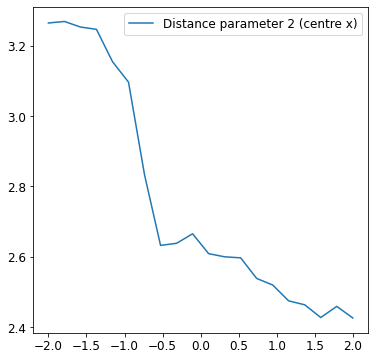

In [547]:
# The constant values are the resut of a previous optimisation
df = vector_learner.calculate_losses(param_ranges=[
     -4.902032852172852, 
      6.172886848449707,
     [-2., 2.], # The x coordinate of the center point
     -5.346111297607422,
      6.553821086883545, 
      3.449993848800659,
     -0.17505674064159393
])
plt.figure(figsize=(6,6))
plt.plot(df.distance_param_2, df.loss, label="Distance parameter 2 (centre x)")
plt.legend()

## Testing 3-Parameter Vector Creation With a Simple Model

This tests an A/V model with 2 + 1 parameters using the simple `kaggle_cnn_a_with_res` for OCR. The result is satisfactory but care must be taken to not get stuck in the extremes of parameter values where gradients tend to vanish.

In [247]:
# learn = None; gc.collect()

if 'learn' not in locals() or learn is None:
    learn = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, 
                            df=get_combined_az_and_tmnist_df, 
                            load_saved=True)
cb = DebugCB()
max_distance = AZ_STATS['letter_height_mean'] / learn.dls.train_ds[0][0].height

vector_learner, image_saver = create_vector_learner(cbs=cb,
                                                    folder="results/test_4_simple_AV3b",
                                                    ocr_learner=learn,
                                                    n_colors_out=1,
                                                    vector_class=AV3VectorRL,
                                                    normalise=False,
                                                    lr=1e-2, 
                                                    max_distance=max_distance,
                                                    # eps=None, # This defaults to 1e-6
                                                    seed=torch.random.seed())

# vector_learner.model[0].distance_params.data = tensor([1., 1.])
# vector_learner.model[0].width_params.data = tensor([0.])
vector_learner.model[0]

FontParamLayer
- distance params:
  0.3335186243057251 (0.32167887687683105)
  -0.32780754566192627 (-0.3165493905544281)
- width params:
  0.8386666774749756 (0.6981843113899231)

In [248]:
vector_learner.render_letter("A")

In [250]:
vector_learner.fit(20, lr=5e-2)
print(vector_learner.model[0])
vector_learner.render_letter("A")

epoch,train_loss,valid_loss,time
0,2.456865,None,00:00
1,2.464739,None,00:00
2,2.472408,None,00:00
3,2.470334,None,00:00
4,2.474181,None,00:00
5,2.475321,None,00:00
6,2.475628,None,00:00
7,2.475393,None,00:00
8,2.474243,None,00:00
9,2.473126,None,00:00


FontParamLayer
- distance params:
  0.3687479496002197 (0.3528960645198822)
  1.1744701862335205 (0.8256999254226685)
- width params:
  3.8387632369995117 (0.9789330959320068)


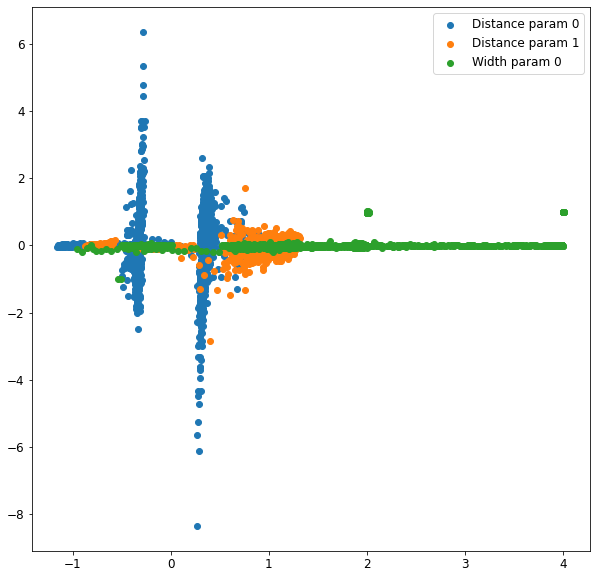

In [251]:
cb.plot()

## Testing Two-Parameter Vector Creation With a Simple Model

This tests an A/V model with added stroke weight parameter using the simple `kaggle_cnn_a_with_res` for OCR. The results are in line with expectations, although the weight parameter seems to get stuck in the ends of the parameter range. This is understandable when looking at the gradient/param value plot, which shows that the gradient vanishes in the extremes.

In [231]:
# learn = None; gc.collect()

if 'learn' not in locals() or learn is None:
    learn = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, 
                            df=get_combined_az_and_tmnist_df, 
                            load_saved=True)
cb = DebugCB()
max_distance = AZ_STATS['letter_height_mean'] / learn.dls.train_ds[0][0].height

vector_learner, image_saver = create_vector_learner(cbs=cb,
                                                    folder="results/test_4_simple_AV2",
                                                    ocr_learner=learn,
                                                    n_colors_out=1,
                                                    vector_class=AV2VectorRL,
                                                    normalise=False,
                                                    lr=1e-2, 
                                                    max_distance=max_distance,
                                                    # eps=None, # This defaults to 1e-6
                                                    seed=torch.random.seed())

# vector_learner.model[0].distance_params.data = tensor([0.])
vector_learner.model[0].width_params.data = tensor([-1.])
vector_learner.model[0]

0.10279881954193115 (0.10243823379278183)-1.0 (0.2689414322376251)

In [235]:
vector_learner.render_letter("A")

In [236]:
vector_learner.fit(20, lr=5e-2)

epoch,train_loss,valid_loss,time
0,2.383969,None,00:00
1,2.385218,None,00:00
2,2.385200,None,00:00
3,2.384479,None,00:00
4,2.384261,None,00:00
5,2.385924,None,00:00
6,2.385159,None,00:00
7,2.385876,None,00:00
8,2.383955,None,00:00
9,2.384181,None,00:00


In [237]:
vector_learner.model[0]

0.6372540593147278 (0.5630269646644592)0.5108917951583862 (0.6250154972076416)

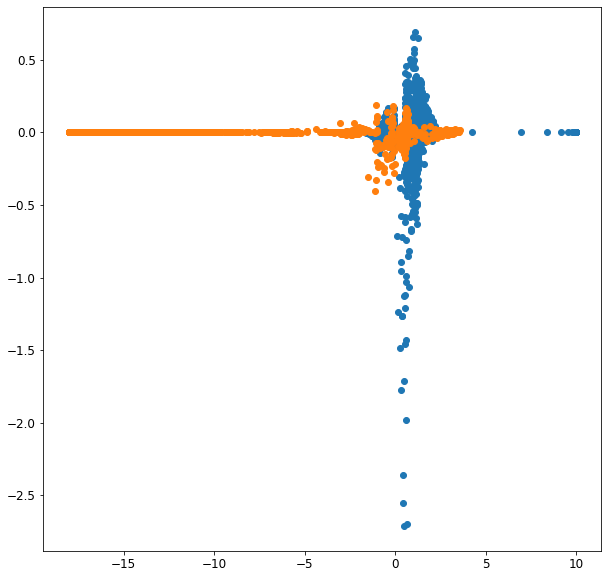

In [238]:
cb.plot()

In [22]:
vector_learner.model[0]

FontParamLayer
- distance params: 0.6502957344055176
- width params:    0.5094169974327087

## Testing Single-Parameter Vector Creation With a Simple Model

This tests a the simplest possible A/V model using the simple `kaggle_cnn_a_with_res` for OCR.

In [209]:
# learn = None; gc.collect()

if learn is None:
    learn = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, 
                            df=get_combined_az_and_tmnist_df, 
                            load_saved=True)
cb = DebugCB()
use_resnet = False
max_distance = AZ_STATS['letter_height_mean'] / learn.dls.train_ds[0][0].height

vector_learner, image_saver = create_vector_learner(cbs=cb,
                                                    folder="results/test_4_simple_AV",
                                                    ocr_learner=None if use_resnet else learn,
                                                    n_colors_out=3 if use_resnet else 1,
                                                    vector_class=AVVectorRL, # ATIVectorRL
                                                    normalise=False,
                                                    debug=False,
                                                    debug_dps=[.5, .5],
                                                    lr=1e-2, 
                                                    max_distance=max_distance,
                                                    # eps=None,
                                                    seed=torch.random.seed())
# vector_learner.fit(10, lr=1e-1)

In [210]:
vector_learner.fit(10, lr=5e-3)

epoch,train_loss,valid_loss,time
0,2.606730,None,00:00
1,2.602211,None,00:00
2,2.603914,None,00:00
3,2.606666,None,00:00
4,2.606377,None,00:00
5,2.607996,None,00:00
6,2.606550,None,00:00
7,2.605079,None,00:00
8,2.610062,None,00:00
9,2.608300,None,00:00


## Testing OCR Models Recognition of Simple Letter Models

### Testing OCR recognition with ResNet and a simpler model

The simple kaggle_cnn_a_with_res model works much as expected but the Resnet model fails to recognize much.

In [373]:
# learn = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, 
#                           df=get_combined_az_and_tmnist_df, 
#                           load_saved=True)
cb = DebugCB()
use_resnet = False

vector_learner, image_saver = create_vector_learner(cbs=cb,
                                                    folder="results/test_4_simple_ATI",
                                                    ocr_learner=None if use_resnet else learn,
                                                    n_colors_out=3 if use_resnet else 1,
                                                    vector_class=AVVectorRL, # ATIVectorRL
                                                    normalise=False,
                                                    debug=True,
                                                    debug_dps=[.5, .5],
                                                    lr=0., 
                                                    eps=None,
                                                    seed=torch.random.seed())

x,y = vector_learner.dls.one_batch()
vocab = get_vocab(vector_learner)
model = vector_learner.model
model.eval()

stats = []
n = 20
last_p = None
for i in range(n):
    # Distance param value [-1., 1.]
    d = 1. / n * (i + 1)
    d = 2 * d - 1.
    if isinstance(model[1], ATIVectorRL): # The first param is the A-shape width, the second crossbar height
        model[0].distance_params.data = tensor([d, 0.4])
    else: # There's only one param
        model[0].distance_params.data = tensor([d])
    # model[1].fixed_seed = 42

    if use_resnet:
        # A. For ResNet OCR @ 3x256x256
        model[1].max_distance = .7
        model[1].stroke_width = tensor(10.)
    else:
        # B. For Simple OCR @ 1x28x28
        model[1].max_distance = AZ_STATS['letter_height_mean'] / vector_learner.model[1].canvas_height
        model[1].stroke_width = tensor(1.)
    
    # Vector prediction    
    p = model(x)
    l = vector_learner.loss_func(p, y)
    stats.append({
        "param": d,
        # "max_distance": model[1].max_distance,
        "loss": vector_learner.loss_func.stored[-1][0],
        "pred": vocab[vector_learner.loss_func.stored[-1][1]],
        "pred_activation": vector_learner.loss_func.stored[-1][2]
    })

def pixel_stats(p=p):
    sample = learn.dls.one_batch()[0]
    stats = []
    for x in [p, sample]:
        stats.append(pd.DataFrame([[y.item() for y in [x.mean(), x.std(), x.min(), x.max(), x.flatten()[0]]]]))
    stats = pd.concat(stats)
    stats.columns = ['Mean', 'Std', 'Min', 'Max', 'First']
    return stats

df = pd.DataFrame(stats)
print("Optimal value for param", df[df.loss == df.loss.min()].param)
df

Debugging: set distance param to [0.5, 0.5]
Optimal value for param 0   -0.9
Name: param, dtype: float64


,param,loss,pred,pred_activation
0,-0.9,3.321970,I,0.998026
1,-0.8,3.321987,I,0.998306
2,-0.7,3.322003,I,0.998561
3,-0.6,3.322038,I,0.999129
4,-0.5,3.322053,I,0.999378
5,-0.4,3.322080,I,0.999801
6,-0.3,3.322083,I,0.999858
7,-0.2,3.322089,I,0.999943
8,-0.1,3.322089,I,0.999945
9,0.0,3.322089,I,0.999952


## Backup

In [ ]:
bs = 1 # Batch size for ocr_loss
canvas_width = canvas_height = 256
folder = "results/letter_A"
ocr_learner = get_ocr_model()
ocr_learner.model.eval()
target_letter = "A"

# Use GPU if available
pydiffvg.set_use_gpu(torch.cuda.is_available())

################################################################
# 1. Create the scene
################################################################

# Three lines
norm = float(canvas_width)

# Shapes
shapes = []
ph = torch.zeros(3, 2) # Placeholder, see _update_and_render
for i in range(1): # XXX 2
    shapes.append(pydiffvg.Polygon(points=ph, stroke_width=ph, is_closed=False))

shape_groups = [
    pydiffvg.ShapeGroup(shape_ids=torch.tensor(list(range(len(shapes)))),
                        fill_color=None,
                        stroke_color=torch.tensor([0., 0., 0., 1.0]),
                        use_even_odd_rule=False)
    ]

# Create scene
scene = Scene(shapes=shapes, shape_groups=shape_groups, folder=folder)

# Parameters to optimise
# points_angle = torch.rand((3, 2), requires_grad=True)
# points_line =  torch.rand((2, 2), requires_grad=True)
# stroke_width = torch.tensor(np.random.random() * .1, requires_grad=True)
dy_param = scene.normalise(125.)
# points_angle = scene.normalise([
#     [ 50.,  50.],
#     [125., 200.],
#     [200.,  50.]
#     ])
# points_line = scene.normalise([
#     [ 20., 80.], 
#     [225., 80.]
#     ])
stroke_width = scene.normalise(6.)
parameters = [dy_param] # [points_angle] # , points_line, stroke_width]

# Define update cycle
def _update_and_render(name: str = None, render_grad=False) -> Tensor:
    """Update the non-normalised shapes for creating scene_args in _render
       and render image."""

    # shapes[0].points = scene.denormalise(points_angle)
    dy = scene.denormalise(dy_param)
    shapes[0].points[0,0] = 50.
    shapes[0].points[0,1] = 250. - dy
    shapes[0].points[1,0] = 125.
    shapes[0].points[1,1] = dy
    shapes[0].points[2,0] = 200.
    shapes[0].points[2,1] = 250. - dy
    # XXX shapes[1].points = scene.denormalise(points_line)
    for s in shapes:
        s.stroke_width = scene.denormalise(stroke_width)

    return scene.render(name=name, render_grad=render_grad)

img = _update_and_render("0_init")

################################################################
# 2. Define static target
################################################################

target = torch.tensor(ocr_learner.dls.vocab.o2i[target_letter]) # Size
target = target.expand(bs) # Expand to batch size

################################################################
# 3. Optimise
################################################################

def ocr_loss(img: Tensor, target: Tensor, parameters: list[Tensor], 
    return_activations = False, **kwargs) -> Union[Tensor, Tuple[Tensor, Tensor]]:
    """Cross entropy loss on OCR model"""

    model = ocr_learner.model
    dls = ocr_learner.dls
    normalise = dls.train.after_batch[1]
    
    # We need to convert the rgba img to one that matches the OCR model's inputs,
    # i.e., from [256, 256, 4] to stat-normalised [bs, 3, 256, 256]
    # Note that the all colours are black so colour, i.e. inverse brightness
    # is dictated by the last item in the 3rd dimension.
    img_1 = img[:,:,3]                   # 256,256; float 0.-1. where 1. is black
    img_2 = 1. - img_1                   # 256,256; float 0.-1. where 0. is black
    img_3 = img_2.expand(3, -1, -1)      # 3,256,256; all 3 channels equal
    img_b = img_3.expand(bs, -1, -1, -1) # Fake batch bs,3,256,256; 

    # normalise.encodes(img_b) does not work for some reason so we do this manually
    # `def encodes(self, x:TensorImage): return (x-self.mean) / self.std`
    img_n = (img_b - normalise.mean) / normalise.std 
    pred = model(img_n)

    # TODO Add further constraints with
    # torch.sigmoid

    loss = F.cross_entropy(pred, target)
    if return_activations:
        act = F.nll_loss(pred, target)
    # print(f"Loss = {loss.item()}", end="\r")

    return (loss, act) if return_activations else loss

# learner = VectorLearner(parameters=parameters, 
#                         forward=_update_and_render,
#                         loss=ocr_loss,
#                         target=target,
#                         lr=5e-3)
# learner.run(100, render_grad=True)

################################################################
# 4. Print out some stats with different params
################################################################

stats = []
y_max = 250. / canvas_width
n_steps = 150
for i in range(n_steps):
    dy_param.data = torch.tensor(i * y_max / n_steps)
    img = _update_and_render()
    loss, act = ocr_loss(img, target, parameters=None, return_activations=True)
    loss.backward(retain_graph=True)

    # This block was just to test if we get the same results by passing
    # a PIL image to predict as with the diffvg Tensor. We do :D
    if False:
        # Create PIL image
        img_np = img.data.numpy()
        img_np = np.clip(img_np, 0.0, 1.0)
        if img_np.ndim == 2: img_np = np.expand_dims(img_np, 2)
        img_np = img_np[:,:,3]                 # 256,256; float 0.-1. where 1. is black
        img_np = 1. - img_np                   # 256,256; float 0.-1. where 0. is black
        img_np = np.expand_dims(img_np, 2)                  # 256,256,1
        img_np = np.repeat(img_np, 3, axis=2)          # 256,256,3; all 3 channels equal

        gamma = 1. # 2.2
        img_np[:, :, :3] = np.power(img_np[:, :, :3], 1.0/gamma)
        img_np = (img_np * 255).astype(np.uint8)
        img_pil = PILImage(PIL.Image.fromarray(img_np))
        preds_2 = ocr_learner.predict(img_pil)[1]
        loss_pil = F.cross_entropy(preds_2.unsqueeze(0), target)

    stats.append({
        'yp': dy_param.data.item(),
        'y1': shapes[0].points[0,1].item(),
        'y2': shapes[0].points[1,1].item(),
        'loss': loss.item(), 
        'act': act.item(),
        'act_abs': act.abs().item(),
        'grad_ya': dy_param.grad.item()
        })

stats = pd.DataFrame(stats)
plt.figure(figsize=(15,15))
plt.plot(stats.yp, stats.grad_ya)
plt.plot(stats.yp, stats.loss * 1e2)


################################################################
# 5. Render the final result and movie
################################################################

# _update_and_render("0_final")
# scene.render_result_video(delete_imgs=True, 
#                           render_grad=False)

## Compare Errors and Grads Between Diffrent OCR Models

In [123]:
def get_error_stats(cut=None, n_steps=50, y_min=0.25, y_max=0.5):

    bs = 1 # Batch size for ocr_loss
    ocr_learner = get_ocr_model(cut=cut)
    ocr_learner.model.eval()
    target_letter = "A"

    # 1. Create the scene
    ph = torch.zeros(3, 2) # Placeholder, see _update_and_render
    shapes = [pydiffvg.Polygon(points=ph, stroke_width=ph, is_closed=False)]
    shape_groups = [
        pydiffvg.ShapeGroup(shape_ids=torch.tensor(list(range(len(shapes)))),
                            fill_color=None, stroke_color=torch.tensor([0., 0., 0., 1.0]),
                            use_even_odd_rule=False)
        ]
    scene = Scene(shapes=shapes, shape_groups=shape_groups, folder=folder)

    # Parameters to optimise
    dy_param = scene.normalise(125.)
    stroke_width = scene.normalise(6.)
    parameters = [dy_param] # [points_angle] # , points_line, stroke_width]

    # Define update cycle
    def _update_and_render(name: str = None, render_grad=False) -> Tensor:
        """Update the non-normalised shapes for creating scene_args in _render
        and render image."""
        dy = scene.denormalise(dy_param)
        shapes[0].points[0,0] = 50.
        shapes[0].points[0,1] = 250. - dy
        shapes[0].points[1,0] = 125.
        shapes[0].points[1,1] = dy
        shapes[0].points[2,0] = 200.
        shapes[0].points[2,1] = 250. - dy
        shapes[0].stroke_width = scene.denormalise(stroke_width)
        return scene.render(name=name, render_grad=render_grad)

    # 2. Define static target
    target = torch.tensor(ocr_learner.dls.vocab.o2i[target_letter]) # Size
    target = target.expand(bs) # Expand to batch size

    # 3. Loss
    def ocr_loss(img: Tensor, target: Tensor, parameters: list[Tensor], 
        return_activations = False, **kwargs) -> Union[Tensor, Tuple[Tensor, Tensor]]:
        """Cross entropy loss on OCR model"""
        model = ocr_learner.model
        dls = ocr_learner.dls
        normalise = dls.train.after_batch[1]
        img_1 = img[:,:,3]                   # 256,256; float 0.-1. where 1. is black
        img_2 = 1. - img_1                   # 256,256; float 0.-1. where 0. is black
        img_3 = img_2.expand(3, -1, -1)      # 3,256,256; all 3 channels equal
        img_b = img_3.expand(bs, -1, -1, -1) # Fake batch bs,3,256,256; 
        img_n = (img_b - normalise.mean) / normalise.std 
        pred = model(img_n)
        loss = F.cross_entropy(pred, target)
        if return_activations:
            act = F.nll_loss(pred, target)
        return (loss, act) if return_activations else loss

    # 4. Print out some stats with different params
    stats = []
    for i in range(n_steps):
        dy_param.data = torch.tensor(y_min + i * (y_max - y_min) / n_steps)
        img = _update_and_render()
        loss, act = ocr_loss(img, target, parameters=None, return_activations=True)
        loss.backward(retain_graph=True)
        stats.append({
            'yp': dy_param.data.item(),
            'y1': shapes[0].points[0,1].item(),
            'y2': shapes[0].points[1,1].item(),
            'loss': loss.item(), 
            'act': act.item(),
            'act_abs': act.abs().item(),
            'grad_ya': dy_param.grad.item()
            })

    stats = pd.DataFrame(stats)
    return stats

def plot_error_stats(cuts = (5, 6, 7, None), width=10):
    n = len(cuts)
    fig, axs = plt.subplots(n, 1, figsize=(width, width * n))
    for i, cut in enumerate(cuts):
        print(f"Plotting cut {i + 1} of {n}", end="\r")
        stats = get_error_stats(cut=cut)
        ax = axs[i]
        ax.scatter(stats.yp, stats.loss * 1e2)
        ax.scatter(stats.yp, stats.grad_ya)
        ax.set_title(f"Cut: {cut if cut is not None else 'None'}")
        ax.set_xlabel("Y param")
        ax.set_ylabel("Loss * 100 / Gradient")
    return fig, axs

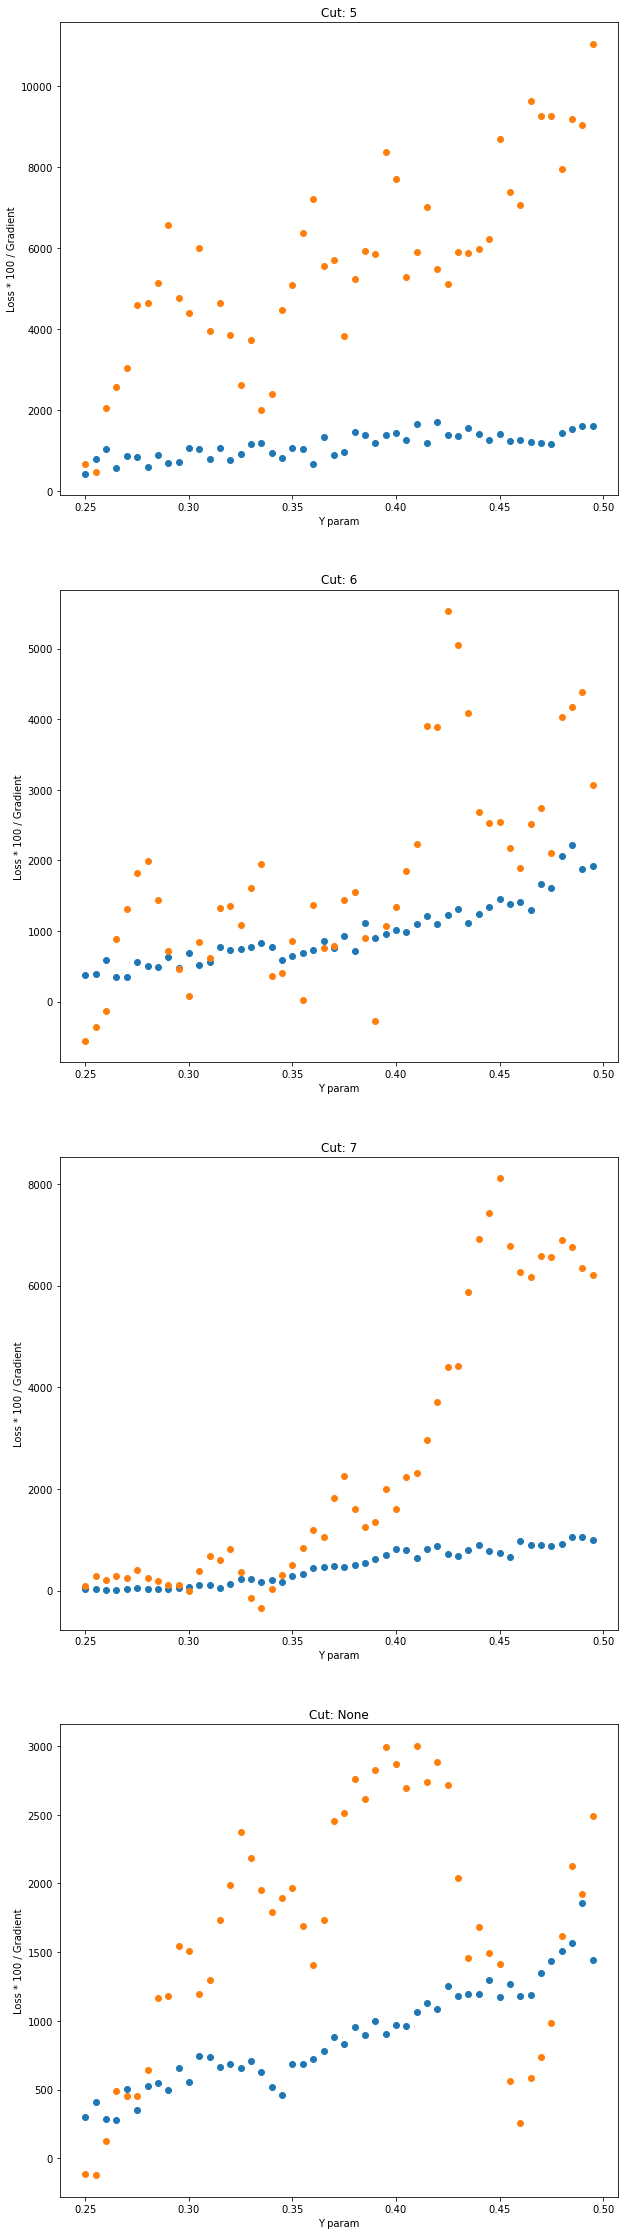

In [124]:
fig, axs = plot_error_stats()

### OK! Test: Check if Tensor and Image Preds Match

In [116]:
bs = 1 # Batch size for ocr_loss
canvas_width = canvas_height = 256
folder = "results/letter_A"
ocr_learner = get_ocr_model()
ocr_learner.model.eval()
target_letter = "A"

# Use GPU if available
pydiffvg.set_use_gpu(torch.cuda.is_available())

################################################################
# 1. Create the scene
################################################################

# Three lines
norm = float(canvas_width)

# Shapes
shapes = []
ph = torch.zeros(3, 2) # Placeholder, see _update_and_render
for i in range(1): # XXX 2
    shapes.append(pydiffvg.Polygon(points=ph, stroke_width=ph, is_closed=False))

shape_groups = [
    pydiffvg.ShapeGroup(shape_ids=torch.tensor(list(range(len(shapes)))),
                        fill_color=None,
                        stroke_color=torch.tensor([0., 0., 0., 1.0]),
                        use_even_odd_rule=False)
    ]

# Create scene
scene = Scene(shapes=shapes, shape_groups=shape_groups, folder=folder)

# Parameters to optimise
dy_param = scene.normalise(125.)
stroke_width = scene.normalise(6.)
parameters = [dy_param] # [points_angle] # , points_line, stroke_width]

# Define update cycle
def _update_and_render(name: str = None, render_grad=False) -> Tensor:
    """Update the non-normalised shapes for creating scene_args in _render
       and render image."""

    # shapes[0].points = scene.denormalise(points_angle)
    dy = scene.denormalise(dy_param)
    shapes[0].points[0,0] = 50.
    shapes[0].points[0,1] = 250. - dy
    shapes[0].points[1,0] = 125.
    shapes[0].points[1,1] = dy
    shapes[0].points[2,0] = 200.
    shapes[0].points[2,1] = 250. - dy
    # XXX shapes[1].points = scene.denormalise(points_line)
    for s in shapes:
        s.stroke_width = scene.denormalise(stroke_width)

    return scene.render(name=name, render_grad=render_grad)

img = _update_and_render("0_init")

################################################################
# 2. Define static target
################################################################

target = torch.tensor(ocr_learner.dls.vocab.o2i[target_letter]) # Size
target = target.expand(bs) # Expand to batch size

################################################################
# 3. Optimise
################################################################

def ocr_loss(img: Tensor, target: Tensor, parameters: list[Tensor], 
    return_activations = False, **kwargs) -> Union[Tensor, Tuple[Tensor, Tensor]]:
    """Cross entropy loss on OCR model"""

    model = ocr_learner.model
    dls = ocr_learner.dls
    normalise = dls.train.after_batch[1]
    
    # We need to convert the rgba img to one that matches the OCR model's inputs,
    # i.e., from [256, 256, 4] to stat-normalised [bs, 3, 256, 256]
    # Note that the all colours are black so colour, i.e. inverse brightness
    # is dictated by the last item in the 3rd dimension.
    img_1 = img[:,:,3]                   # 256,256; float 0.-1. where 1. is black
    img_2 = 1. - img_1                   # 256,256; float 0.-1. where 0. is black
    img_3 = img_2.expand(3, -1, -1)      # 3,256,256; all 3 channels equal
    img_b = img_3.expand(bs, -1, -1, -1) # Fake batch bs,3,256,256; 

    # normalise.encodes(img_b) does not work for some reason so we do this manually
    # `def encodes(self, x:TensorImage): return (x-self.mean) / self.std`
    img_n = (img_b - normalise.mean) / normalise.std 
    pred = model(img_n)

    # TODO Add further constraints with
    # torch.sigmoid

    loss = F.cross_entropy(pred, target)
    if return_activations:
        act = F.nll_loss(pred, target)
    # print(f"Loss = {loss.item()}", end="\r")

    return (loss, act) if return_activations else loss

################################################################
# 4. Print out some stats with different params
################################################################

stats = []
y_max = 250. / canvas_width
n_steps = 10
for i in range(n_steps):
    dy_param.data = torch.tensor(i * y_max / n_steps)
    img = _update_and_render()
    loss, act = ocr_loss(img, target, parameters=None, return_activations=True)
    loss.backward(retain_graph=True)

    # This block was just to test if we get the same results by passing
    # a PIL image to predict as with the diffvg Tensor. We do :D
    img_np = img.data.numpy()
    img_np = np.clip(img_np, 0.0, 1.0)
    if img_np.ndim == 2: img_np = np.expand_dims(img_np, 2)
    img_np = img_np[:,:,3]                 # 256,256; float 0.-1. where 1. is black
    img_np = 1. - img_np                   # 256,256; float 0.-1. where 0. is black
    img_np = np.expand_dims(img_np, 2)                  # 256,256,1
    img_np = np.repeat(img_np, 3, axis=2)          # 256,256,3; all 3 channels equal

    gamma = 1. # 2.2
    img_np[:, :, :3] = np.power(img_np[:, :, :3], 1.0/gamma)
    img_np = (img_np * 255).astype(np.uint8)
    img_pil = PILImage(PIL.Image.fromarray(img_np))
    preds_2 = ocr_learner.predict(img_pil)[1]
    loss_pil = F.cross_entropy(preds_2.unsqueeze(0), target)

    stats.append({
        'yp': dy_param.data.item(),
        'y1': shapes[0].points[0,1].item(),
        'y2': shapes[0].points[1,1].item(),
        'loss': loss.item(), 
        'loss_pil': loss_pil.item(), 
        'act': act.item(),
        'act_abs': act.abs().item(),
        'grad_ya': dy_param.grad.item()
        })

stats = pd.DataFrame(stats)
stats.loss - stats.loss_pil

0    0.000120
1   -0.000575
2    0.000674
3    0.002586
4   -0.004501
5    0.000925
6    0.014111
7   -0.007425
8    0.007559
9    0.021619
dtype: float64

### Test: OCR Learner Prediction Stats

> Calculating some statistics on the prediction stats between different exemplars of the same class.

In [16]:
def plot_ocr_pred_stats(width=10):
    cuts = (5, 6, 7, None)
    n = len(cuts)
    _, axs = plt.subplots(n, 1, figsize=(width, width * n))
    for i, cut in enumerate(cuts):
        ocr_learner = get_ocr_model(cut=cut)
        preds, targs = ocr_learner.get_preds()
        ce_loss = nn.CrossEntropyLoss(reduction='none')
        nll_loss = nn.NLLLoss(reduction='none')
        
        correct = nll_loss(torch.softmax(preds, dim=1), targs).abs() > .5
        losses = ce_loss(preds, targs)
        activations = nll_loss(preds, targs)
        pred_stats = pd.DataFrame()
        pred_stats["Correct"] = correct
        pred_stats["CE_Loss"] = losses
        # pred_stats["CE Loss Log"] = losses.log()
        pred_stats["Activation"] = activations.abs()
        pred_stats["Loss_Act_Ratio"] = losses / activations.abs()

        # rat = pred_stats[pred_stats.Correct == True].Loss_Act_Ratio
        # rat.mean(), rat.std(), rat.min(), rat.max()

        correct = pred_stats[pred_stats.Correct == True]
        correct = correct[correct.CE_Loss < 1e-4]
        incorrect = pred_stats[pred_stats.Correct == False]
        print(len(correct), len(incorrect))
        ax = axs[i]
        ax.scatter(correct.CE_Loss, correct.Activation)
        ax.set_title(f"Cut: {cut if cut is not None else 'None'}")
        ax.set_xlabel("CE Loss")
        ax.set_ylabel("Activation")
        # plt.scatter(incorrect.CE_Loss, incorrect.Activation)

546 84


1162 54


1878 21


1979 15


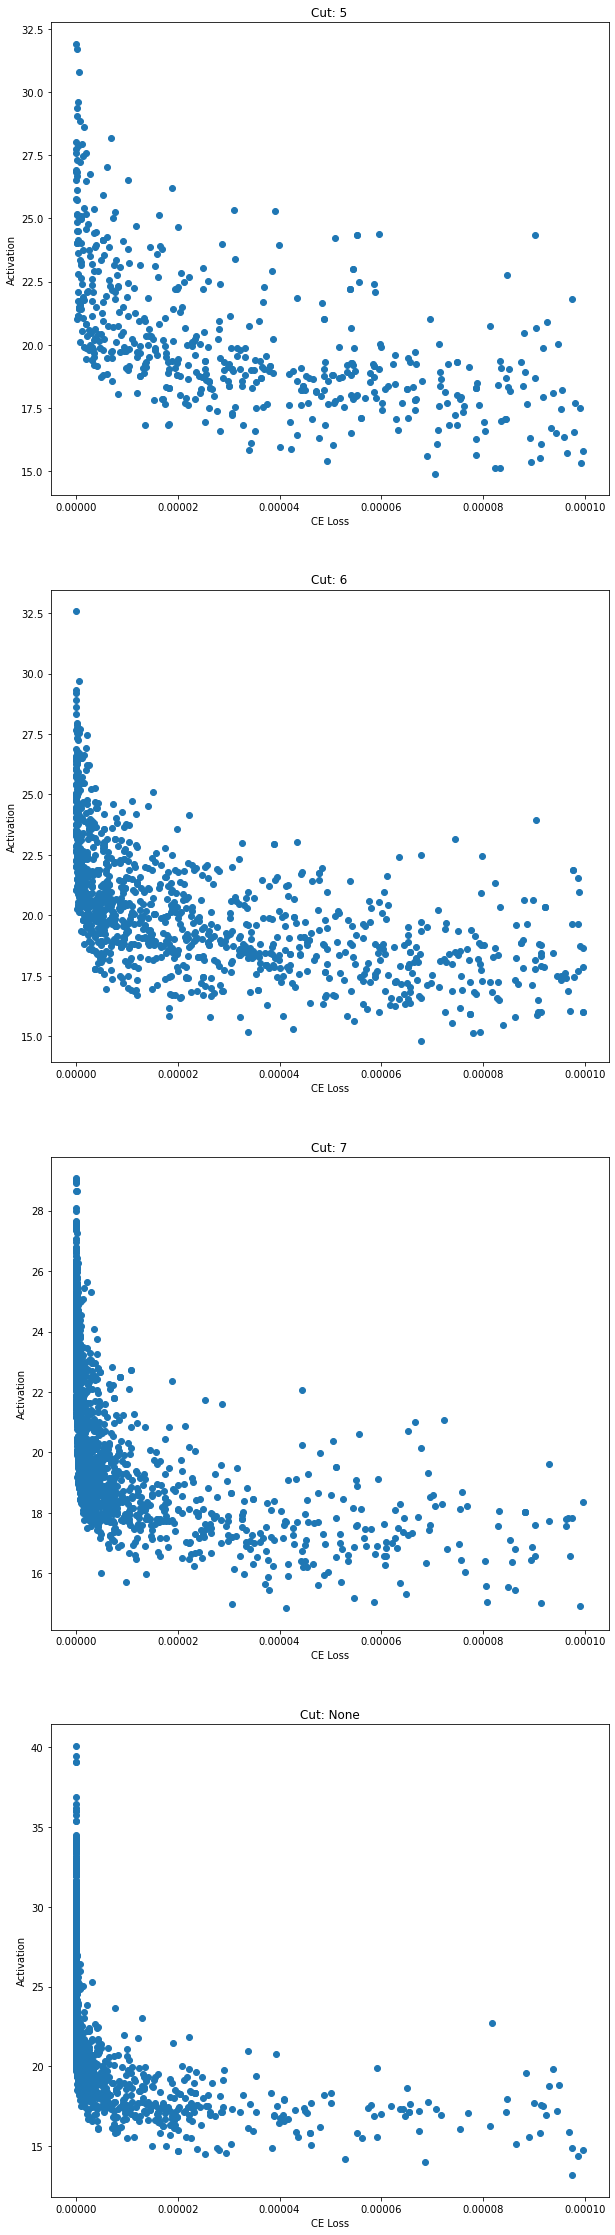

In [17]:
plot_ocr_pred_stats()

### Test: Optimise Random Params to Target Image

> Problem: Optimiser Gets Stuck at Local Minima

In [258]:
folder = "results/letter_A_pixdiff"
canvas_width = canvas_height = 256

# Use GPU if available
pydiffvg.set_use_gpu(torch.cuda.is_available())

################################################################
# 1. Create the scene
################################################################

# Shapes
shapes = []
ph = torch.tensor(0.) # Placeholder, see _update_and_render
for i in range(2):
    shapes.append(pydiffvg.Polygon(points=ph, stroke_width=ph, is_closed=False))

shape_groups = [
    pydiffvg.ShapeGroup(shape_ids=torch.tensor(list(range(len(shapes)))),
                        fill_color=None,
                        stroke_color=torch.tensor([0., 0., 0., 1.0]),
                        use_even_odd_rule=False)
    ]

# Create scene
scene = Scene(shapes=shapes, shape_groups=shape_groups, folder=folder)

# stroke_width = scene.normalise(10.)
points_angle = torch.rand((3, 2), requires_grad=True)
points_line =  torch.rand((2, 2), requires_grad=True)
stroke_width = torch.tensor(np.random.random() * .1, requires_grad=True)
parameters = [points_angle, points_line, stroke_width]

# Define update cycle
def _update_and_render(name: str = None, render_grad=False) -> Tensor:
    """Update the non-normalised shapes for creating scene_args in _render
       and render image."""
    shapes[0].points = scene.denormalise(points_angle)
    shapes[1].points = scene.denormalise(points_line)
    for s in shapes:
        s.stroke_width = scene.denormalise(stroke_width)
    return scene.render(name=name, render_grad=render_grad)

_update_and_render("0_init")

################################################################
# 2. Create the target Tensor
################################################################

target = read_image(f"{folder}/0_letter_A.png")

################################################################
# 3. Optimise
################################################################

def l2plus_loss(img: Tensor, target: Tensor, parameters: list[Tensor], **kwargs):
    """L2 loss function with added penalty for stroke width"""
    return (img - target).pow(2).sum() + (parameters[2] * 256).pow(2)

learner = VectorLearner(parameters=parameters, 
                        forward=_update_and_render,
                        loss=l2plus_loss,
                        target=target,
                        lr=2e-2)
learner.run(50, render_grad=True)

################################################################
# 4. Render the final result and movie
################################################################

_update_and_render("0_final")
scene.render_result_video(render_grad=True, delete_imgs=True)

Rendering video done!s:   150863


## Archived tests

In [ ]:
if False:
    learn = get_ocr_model()
    dls = learn.dls
    normalise = dls.train.after_batch[1]
    # res = learn.predict(img)
    # y_1h = F.one_hot(y, num_classes=dls.c).float()
    # pred = res[1]
    # inp = torch.reshape(pred, (1, -1))
    # tar = torch.reshape(y, (-1,))
    # F.cross_entropy(inp, tar)

    # Using predict() to test image
    # img is from Scene.render
    vimg = img[:,:,3] # 256,256; float 0.-1.
    print(dls.vocab)
    flimg = (vimg * 255.)  # 256,256; float 0.-255.
    pred = learn.predict(flimg)[1]
    pred

    # Using model() to test image
    # img is from Scene.render
    # Note that the all colours are black so colour, i.e. inverse brightness
    # is dictated by the last item in the 3rd dimension.
    img_1 = img[:,:,3]   # 256,256; float 0.-1. where 1. is black
    img_2 = 1. - img_1   # 256,256; float 0.-1. where 0. is black
    img_3 = img_2.expand(3, -1, -1) # 3,256,256; float 0.-1. where 0. is black and all 3 channels equal
    img_b = img_3.expand(1, -1, -1, -1) # Fake batch 1,3,256,256; 
    normalise = dls.train.after_batch[1]
    # normalise.encodes(img_b) does not work for some reason so we do this manually
    # `def encodes(self, x:TensorImage): return (x-self.mean) / self.std`
    img_n = (img_b - normalise.mean) / normalise.std 
    # print(img_n.min(), img_n.max(), img_n.mean())
    # Unnecessary: expand to a fake batch for the model
    # img_n_64 = img_n.expand(dls.bs, -1, -1, -1)
    pred_b = learn.model(img_n)
    print(res)
    loss = F.cross_entropy
    # Target is the letter A
    target_letter = "A"
    target = torch.tensor(dls.vocab.o2i[target_letter]) # Size 1
    target_b = target.expand(img_n.size(0)) # Match to pred size
    loss(pred_b, target_b)

    # pimg is from dls
    pimg = dls.train.one_batch()[0]
    t = pimg.permute(1,2,0).type(torch.uint8)
    t.max()
    pimg2 = PILImage.create("data/font_images/A_ABeeZee-regular.png")
    learn.predict(pimg2)

In [5]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted 02_ocrlearner.ipynb.
Converted 03_fontlearner.ipynb.
Converted index.ipynb.
